***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [2]:
image_dir = Path('./Imagenes/Trayectorias_dominio_tiempo_frecuencia/longitud_28/raw-img-v3-COMPLETO')

file_paths = list(image_dir.rglob("*.jpg")) + \
             list(image_dir.rglob("*.jpeg")) + \
             list(image_dir.rglob("*.png"))

complete_df = pd.DataFrame()
complete_df['file_name'] = [str(p) for p in file_paths]
complete_df['class_name'] = complete_df['file_name'].map(lambda x: Path(x).parent.name)

### COMPROBACIÓN ###
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)


Número total de imágenes: 3884
class_name
Fishing      949
Container    933
Cruise       918
Tanker       688
Cargo        396
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 3110
class_name
Fishing      760
Container    747
Cruise       735
Tanker       551
Cargo        317
Name: count, dtype: int64

Nº de imágenes en test: 774
class_name
Fishing      189
Container    186
Cruise       183
Tanker       137
Cargo         79
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
1  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
2  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
3  Imagenes\Trayectorias_dominio_tiempo_frecuenci...      Cargo
4  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
5  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
6  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
7  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Cruise
8  Imagenes\Trayectorias_dominio_tiempo_frecuenci...     Tanker
9  Imagenes\Trayectorias_dominio_ti

***Imágenes de entrenamiento y test antes del pre-procesado :***

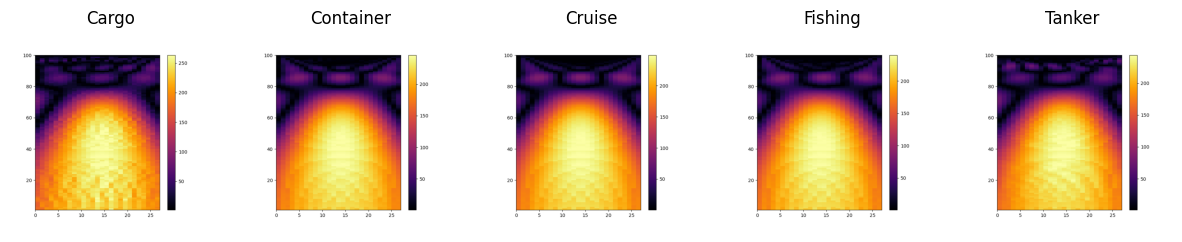

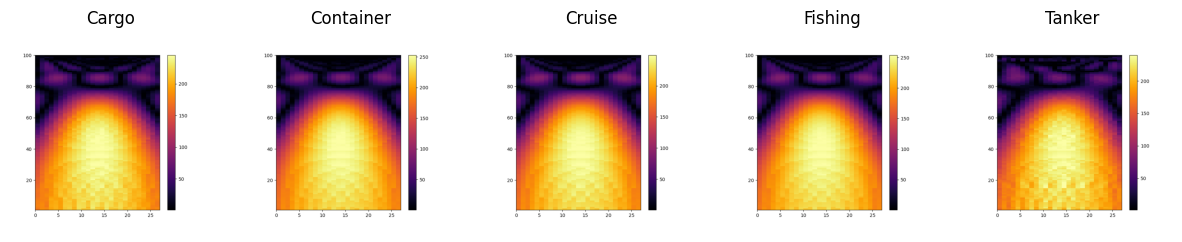

In [4]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    grouped = df.groupby('class_name')
    
    for i, (class_name, group) in enumerate(grouped):
        image_path = group['file_name'].iloc[0]
        image = Image.open(image_path).convert("RGB")
        
        plt.subplot(1, len(grouped), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [5]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.ToTensor()])

def preprocesado_imagen(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image

for index, row in train_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_train.append(image_tensor)
    y_train.append(row['class_name'])

for index, row in test_df.iterrows():
    image_tensor = preprocesado_imagen(row['file_name'])
    X_test.append(image_tensor)
    y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

### COMPROBACIÓN ###
print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)


cuda disponible
X_train: torch.Size([3110, 3, 227, 227]) cpu
y_train: torch.Size([3110]) cpu
X_test: torch.Size([774, 3, 227, 227]) cpu
y_test: torch.Size([774]) cpu


# ***AlexNet :***

In [ ]:
def get_alexnet_model(num_classes, pretrained):
    if pretrained:
        modelo = alexnet(weights=AlexNet_Weights.DEFAULT)
    else:
        modelo = alexnet(weights=None)

    modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, num_classes)

    if pretrained:
        for param in modelo.features.parameters():
            param.requires_grad = False
            
        for param in modelo.classifier[6].parameters():
            param.requires_grad = True

    return modelo

# ***ResNet50 :***

In [ ]:
def get_resnet50_model(num_classes, pretrained):
    if pretrained:
        modelo = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        modelo = resnet50(weights=None)

    modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.fc.parameters():
            param.requires_grad = True

    return modelo

# ***DenseNet121 :***

In [6]:
def get_densenet121_model(num_classes, pretrained):
    if pretrained:
        modelo = densenet121(weights=DenseNet121_Weights.DEFAULT)
    else:
        modelo = densenet121(weights=None)

    modelo.classifier = nn.Linear(modelo.classifier.in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier.parameters():
            param.requires_grad = True

    return modelo

# ***ConvNeXt Tiny :***

In [6]:
def get_convnext_tiny_model(num_classes, pretrained):
    if pretrained:
        modelo = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
    else:
        modelo = convnext_tiny(weights=None)

    modelo.classifier[2] = nn.Linear(modelo.classifier[2].in_features, num_classes)

    if pretrained:
        for param in modelo.parameters():
            param.requires_grad = False

        for param in modelo.classifier[2].parameters():
            param.requires_grad = True

    return modelo

***Configuración del modelo :***

In [7]:
k_folds = 5
batch_size = 32
num_epochs = 100
num_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

***Entrenamiento del modelo :***

In [8]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

    #nombre_modelo = "AlexNet"
    #modelo = get_alexnet_model(num_classes=num_classes, pretrained=False).to(device)
    
    #nombre_modelo = "ResNet50"
    #modelo = get_resnet50_model(num_classes=num_classes, pretrained=True).to(device)
    
    #nombre_modelo = "DenseNet121"
    #modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)
    
    nombre_modelo = "ConvNext_Tiny"
    modelo = get_convnext_tiny_model(num_classes=num_classes, pretrained=True).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = modelo(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        modelo.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                output = modelo(images)
                loss = criterion(output, labels)
                _, predicted = torch.max(output, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v3/representacion_3/longitud_28"
        os.makedirs(save_path, exist_ok=True)
        torch.save(modelo.state_dict(), f"{save_path}/{nombre_modelo}_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/100: 100%|██████████| 78/78 [00:28<00:00,  2.76it/s]


Fold 1 - Epoch 1 ✅ | Train Acc: 20.90% - Train Loss: 1.6263 | Val Acc: 24.12% - Val Loss: 1.6362


Fold 1 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.30it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 20.02% - Train Loss: 1.6281 | Val Acc: 23.79% - Val Loss: 1.6367


Fold 1 | Epoch 3/100: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 22.31% - Train Loss: 1.6214 | Val Acc: 22.99% - Val Loss: 1.6253


Fold 1 | Epoch 4/100: 100%|██████████| 78/78 [00:15<00:00,  4.99it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 19.13% - Train Loss: 1.6328 | Val Acc: 25.56% - Val Loss: 1.6166


Fold 1 | Epoch 5/100: 100%|██████████| 78/78 [00:15<00:00,  4.93it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 21.34% - Train Loss: 1.6218 | Val Acc: 25.88% - Val Loss: 1.5945


Fold 1 | Epoch 6/100: 100%|██████████| 78/78 [00:15<00:00,  4.91it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 21.58% - Train Loss: 1.6269 | Val Acc: 18.97% - Val Loss: 1.6004


Fold 1 | Epoch 7/100: 100%|██████████| 78/78 [00:15<00:00,  4.91it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 22.55% - Train Loss: 1.6168 | Val Acc: 19.77% - Val Loss: 1.5930


Fold 1 | Epoch 8/100: 100%|██████████| 78/78 [00:16<00:00,  4.85it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 22.87% - Train Loss: 1.6078 | Val Acc: 26.05% - Val Loss: 1.5962


Fold 1 | Epoch 9/100: 100%|██████████| 78/78 [00:16<00:00,  4.85it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 23.15% - Train Loss: 1.6127 | Val Acc: 18.33% - Val Loss: 1.6169


Fold 1 | Epoch 10/100: 100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 22.15% - Train Loss: 1.6227 | Val Acc: 27.01% - Val Loss: 1.5960


Fold 1 | Epoch 11/100: 100%|██████████| 78/78 [00:16<00:00,  4.83it/s]


Fold 1 - Epoch 11 ✅ | Train Acc: 22.71% - Train Loss: 1.6166 | Val Acc: 20.42% - Val Loss: 1.6649


Fold 1 | Epoch 12/100: 100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


Fold 1 - Epoch 12 ✅ | Train Acc: 22.59% - Train Loss: 1.6231 | Val Acc: 23.15% - Val Loss: 1.6103


Fold 1 | Epoch 13/100: 100%|██████████| 78/78 [00:16<00:00,  4.66it/s]


Fold 1 - Epoch 13 ✅ | Train Acc: 21.70% - Train Loss: 1.6229 | Val Acc: 11.09% - Val Loss: 1.6703


Fold 1 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.22it/s]


Fold 1 - Epoch 14 ✅ | Train Acc: 22.03% - Train Loss: 1.6179 | Val Acc: 27.49% - Val Loss: 1.6006


Fold 1 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.21it/s]


Fold 1 - Epoch 15 ✅ | Train Acc: 20.98% - Train Loss: 1.6192 | Val Acc: 27.81% - Val Loss: 1.6306


Fold 1 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.39it/s]


Fold 1 - Epoch 16 ✅ | Train Acc: 22.91% - Train Loss: 1.6099 | Val Acc: 27.49% - Val Loss: 1.6053


Fold 1 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.39it/s]


Fold 1 - Epoch 17 ✅ | Train Acc: 21.86% - Train Loss: 1.6090 | Val Acc: 22.67% - Val Loss: 1.5988


Fold 1 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 18 ✅ | Train Acc: 23.07% - Train Loss: 1.6060 | Val Acc: 16.88% - Val Loss: 1.6325


Fold 1 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.38it/s]


Fold 1 - Epoch 19 ✅ | Train Acc: 21.99% - Train Loss: 1.6144 | Val Acc: 21.70% - Val Loss: 1.5876


Fold 1 | Epoch 20/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 1 - Epoch 20 ✅ | Train Acc: 23.07% - Train Loss: 1.6038 | Val Acc: 25.72% - Val Loss: 1.6011


Fold 1 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 1 - Epoch 21 ✅ | Train Acc: 22.75% - Train Loss: 1.6096 | Val Acc: 23.95% - Val Loss: 1.6245


Fold 1 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 22 ✅ | Train Acc: 22.55% - Train Loss: 1.6148 | Val Acc: 24.28% - Val Loss: 1.6007


Fold 1 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 1 - Epoch 23 ✅ | Train Acc: 23.27% - Train Loss: 1.6036 | Val Acc: 15.11% - Val Loss: 1.6297


Fold 1 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 24 ✅ | Train Acc: 22.75% - Train Loss: 1.6100 | Val Acc: 27.97% - Val Loss: 1.5973


Fold 1 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 1 - Epoch 25 ✅ | Train Acc: 23.95% - Train Loss: 1.6132 | Val Acc: 16.88% - Val Loss: 1.6330


Fold 1 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 1 - Epoch 26 ✅ | Train Acc: 23.63% - Train Loss: 1.5976 | Val Acc: 25.24% - Val Loss: 1.6260


Fold 1 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 27 ✅ | Train Acc: 23.43% - Train Loss: 1.6031 | Val Acc: 21.86% - Val Loss: 1.6488


Fold 1 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 28 ✅ | Train Acc: 22.79% - Train Loss: 1.6095 | Val Acc: 25.72% - Val Loss: 1.6057


Fold 1 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 1 - Epoch 29 ✅ | Train Acc: 22.31% - Train Loss: 1.6152 | Val Acc: 26.21% - Val Loss: 1.6151


Fold 1 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 30 ✅ | Train Acc: 22.63% - Train Loss: 1.6133 | Val Acc: 22.51% - Val Loss: 1.6125


Fold 1 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 31 ✅ | Train Acc: 22.91% - Train Loss: 1.6056 | Val Acc: 24.44% - Val Loss: 1.6577


Fold 1 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 32 ✅ | Train Acc: 23.35% - Train Loss: 1.6150 | Val Acc: 18.33% - Val Loss: 1.6285


Fold 1 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 33 ✅ | Train Acc: 22.67% - Train Loss: 1.6108 | Val Acc: 22.67% - Val Loss: 1.5969


Fold 1 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 1 - Epoch 34 ✅ | Train Acc: 23.71% - Train Loss: 1.6243 | Val Acc: 27.01% - Val Loss: 1.5966


Fold 1 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 35 ✅ | Train Acc: 24.04% - Train Loss: 1.6080 | Val Acc: 19.29% - Val Loss: 1.6310


Fold 1 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 36 ✅ | Train Acc: 22.79% - Train Loss: 1.6175 | Val Acc: 16.56% - Val Loss: 1.6133


Fold 1 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 37 ✅ | Train Acc: 22.31% - Train Loss: 1.6106 | Val Acc: 24.76% - Val Loss: 1.6099


Fold 1 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 38 ✅ | Train Acc: 23.63% - Train Loss: 1.6032 | Val Acc: 23.31% - Val Loss: 1.5904


Fold 1 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 39 ✅ | Train Acc: 24.72% - Train Loss: 1.5996 | Val Acc: 27.33% - Val Loss: 1.6232


Fold 1 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 1 - Epoch 40 ✅ | Train Acc: 23.71% - Train Loss: 1.6105 | Val Acc: 19.13% - Val Loss: 1.6276


Fold 1 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 41 ✅ | Train Acc: 24.68% - Train Loss: 1.6004 | Val Acc: 27.97% - Val Loss: 1.6034


Fold 1 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 42 ✅ | Train Acc: 24.08% - Train Loss: 1.6164 | Val Acc: 25.08% - Val Loss: 1.5941


Fold 1 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 1 - Epoch 43 ✅ | Train Acc: 25.08% - Train Loss: 1.6024 | Val Acc: 20.58% - Val Loss: 1.5996


Fold 1 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.48it/s]


Fold 1 - Epoch 44 ✅ | Train Acc: 25.04% - Train Loss: 1.6020 | Val Acc: 19.29% - Val Loss: 1.6005


Fold 1 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 1 - Epoch 45 ✅ | Train Acc: 23.47% - Train Loss: 1.6051 | Val Acc: 26.69% - Val Loss: 1.6267


Fold 1 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 46 ✅ | Train Acc: 23.71% - Train Loss: 1.6039 | Val Acc: 25.24% - Val Loss: 1.6217


Fold 1 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 47 ✅ | Train Acc: 23.47% - Train Loss: 1.6041 | Val Acc: 18.65% - Val Loss: 1.5950


Fold 1 | Epoch 48/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 1 - Epoch 48 ✅ | Train Acc: 22.47% - Train Loss: 1.6074 | Val Acc: 22.67% - Val Loss: 1.6072


Fold 1 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 49 ✅ | Train Acc: 23.87% - Train Loss: 1.6039 | Val Acc: 19.45% - Val Loss: 1.6105


Fold 1 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 50 ✅ | Train Acc: 22.67% - Train Loss: 1.6248 | Val Acc: 18.33% - Val Loss: 1.5965


Fold 1 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 1 - Epoch 51 ✅ | Train Acc: 23.83% - Train Loss: 1.5988 | Val Acc: 21.86% - Val Loss: 1.6236


Fold 1 | Epoch 52/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 52 ✅ | Train Acc: 24.80% - Train Loss: 1.6013 | Val Acc: 28.14% - Val Loss: 1.6487


Fold 1 | Epoch 53/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 53 ✅ | Train Acc: 24.80% - Train Loss: 1.6068 | Val Acc: 17.04% - Val Loss: 1.6544


Fold 1 | Epoch 54/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 1 - Epoch 54 ✅ | Train Acc: 23.51% - Train Loss: 1.6025 | Val Acc: 16.24% - Val Loss: 1.6134


Fold 1 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 55 ✅ | Train Acc: 25.64% - Train Loss: 1.5999 | Val Acc: 16.72% - Val Loss: 1.6081


Fold 1 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 56 ✅ | Train Acc: 24.16% - Train Loss: 1.5946 | Val Acc: 18.65% - Val Loss: 1.6139


Fold 1 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 57 ✅ | Train Acc: 23.79% - Train Loss: 1.6045 | Val Acc: 22.03% - Val Loss: 1.5975


Fold 1 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 58 ✅ | Train Acc: 25.40% - Train Loss: 1.5944 | Val Acc: 24.76% - Val Loss: 1.5985


Fold 1 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 59 ✅ | Train Acc: 22.87% - Train Loss: 1.5974 | Val Acc: 17.20% - Val Loss: 1.6061


Fold 1 | Epoch 60/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 60 ✅ | Train Acc: 23.59% - Train Loss: 1.6071 | Val Acc: 18.65% - Val Loss: 1.5917


Fold 1 | Epoch 61/100: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


Fold 1 - Epoch 61 ✅ | Train Acc: 24.44% - Train Loss: 1.5976 | Val Acc: 25.08% - Val Loss: 1.6109


Fold 1 | Epoch 62/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 1 - Epoch 62 ✅ | Train Acc: 23.35% - Train Loss: 1.5922 | Val Acc: 17.52% - Val Loss: 1.6141


Fold 1 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 63 ✅ | Train Acc: 23.91% - Train Loss: 1.5994 | Val Acc: 26.69% - Val Loss: 1.6051


Fold 1 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 1 - Epoch 64 ✅ | Train Acc: 23.83% - Train Loss: 1.5998 | Val Acc: 24.12% - Val Loss: 1.5960


Fold 1 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 1 - Epoch 65 ✅ | Train Acc: 23.75% - Train Loss: 1.6054 | Val Acc: 22.99% - Val Loss: 1.6269


Fold 1 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 66 ✅ | Train Acc: 22.95% - Train Loss: 1.6062 | Val Acc: 24.12% - Val Loss: 1.5936


Fold 1 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 67 ✅ | Train Acc: 25.72% - Train Loss: 1.5935 | Val Acc: 26.85% - Val Loss: 1.6147


Fold 1 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 1 - Epoch 68 ✅ | Train Acc: 24.28% - Train Loss: 1.6016 | Val Acc: 28.94% - Val Loss: 1.5973


Fold 1 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 69 ✅ | Train Acc: 24.48% - Train Loss: 1.5975 | Val Acc: 23.63% - Val Loss: 1.6177


Fold 1 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 70 ✅ | Train Acc: 24.88% - Train Loss: 1.5944 | Val Acc: 27.81% - Val Loss: 1.6146


Fold 1 | Epoch 71/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 71 ✅ | Train Acc: 24.84% - Train Loss: 1.5976 | Val Acc: 19.13% - Val Loss: 1.6455


Fold 1 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 72 ✅ | Train Acc: 23.79% - Train Loss: 1.6043 | Val Acc: 21.54% - Val Loss: 1.6131


Fold 1 | Epoch 73/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 73 ✅ | Train Acc: 23.87% - Train Loss: 1.5993 | Val Acc: 24.60% - Val Loss: 1.6092


Fold 1 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 74 ✅ | Train Acc: 25.16% - Train Loss: 1.5962 | Val Acc: 22.99% - Val Loss: 1.5989


Fold 1 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 1 - Epoch 75 ✅ | Train Acc: 24.68% - Train Loss: 1.5913 | Val Acc: 18.81% - Val Loss: 1.5963


Fold 1 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 76 ✅ | Train Acc: 24.12% - Train Loss: 1.5934 | Val Acc: 26.37% - Val Loss: 1.5951


Fold 1 | Epoch 77/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 1 - Epoch 77 ✅ | Train Acc: 24.56% - Train Loss: 1.6000 | Val Acc: 17.20% - Val Loss: 1.6006


Fold 1 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 78 ✅ | Train Acc: 23.59% - Train Loss: 1.5948 | Val Acc: 17.68% - Val Loss: 1.6022


Fold 1 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 79 ✅ | Train Acc: 25.00% - Train Loss: 1.5987 | Val Acc: 25.72% - Val Loss: 1.6269


Fold 1 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 80 ✅ | Train Acc: 24.92% - Train Loss: 1.5932 | Val Acc: 24.12% - Val Loss: 1.6551


Fold 1 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 81 ✅ | Train Acc: 24.04% - Train Loss: 1.5995 | Val Acc: 25.40% - Val Loss: 1.6169


Fold 1 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 82 ✅ | Train Acc: 23.95% - Train Loss: 1.6059 | Val Acc: 24.76% - Val Loss: 1.6875


Fold 1 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 83 ✅ | Train Acc: 25.52% - Train Loss: 1.5948 | Val Acc: 27.97% - Val Loss: 1.6201


Fold 1 | Epoch 84/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 84 ✅ | Train Acc: 22.87% - Train Loss: 1.5968 | Val Acc: 26.37% - Val Loss: 1.5985


Fold 1 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 85 ✅ | Train Acc: 24.40% - Train Loss: 1.6018 | Val Acc: 26.53% - Val Loss: 1.6082


Fold 1 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 86 ✅ | Train Acc: 24.04% - Train Loss: 1.5967 | Val Acc: 24.60% - Val Loss: 1.5952


Fold 1 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 1 - Epoch 87 ✅ | Train Acc: 24.36% - Train Loss: 1.5951 | Val Acc: 27.33% - Val Loss: 1.6088


Fold 1 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 1 - Epoch 88 ✅ | Train Acc: 24.88% - Train Loss: 1.5938 | Val Acc: 25.24% - Val Loss: 1.5980


Fold 1 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 89 ✅ | Train Acc: 22.67% - Train Loss: 1.6097 | Val Acc: 27.33% - Val Loss: 1.6547


Fold 1 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 90 ✅ | Train Acc: 25.20% - Train Loss: 1.5887 | Val Acc: 22.67% - Val Loss: 1.5990


Fold 1 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 1 - Epoch 91 ✅ | Train Acc: 25.08% - Train Loss: 1.5963 | Val Acc: 17.68% - Val Loss: 1.6466


Fold 1 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 92 ✅ | Train Acc: 23.91% - Train Loss: 1.5948 | Val Acc: 25.56% - Val Loss: 1.6490


Fold 1 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 93 ✅ | Train Acc: 24.16% - Train Loss: 1.5929 | Val Acc: 25.72% - Val Loss: 1.6099


Fold 1 | Epoch 94/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 1 - Epoch 94 ✅ | Train Acc: 24.84% - Train Loss: 1.5917 | Val Acc: 18.17% - Val Loss: 1.5971


Fold 1 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 95 ✅ | Train Acc: 24.56% - Train Loss: 1.5995 | Val Acc: 21.54% - Val Loss: 1.6351


Fold 1 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 1 - Epoch 96 ✅ | Train Acc: 24.00% - Train Loss: 1.6015 | Val Acc: 24.92% - Val Loss: 1.6248


Fold 1 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 1 - Epoch 97 ✅ | Train Acc: 25.76% - Train Loss: 1.5911 | Val Acc: 23.47% - Val Loss: 1.5903


Fold 1 | Epoch 98/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 98 ✅ | Train Acc: 25.12% - Train Loss: 1.5958 | Val Acc: 22.03% - Val Loss: 1.6136


Fold 1 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 1 - Epoch 99 ✅ | Train Acc: 26.53% - Train Loss: 1.5837 | Val Acc: 21.22% - Val Loss: 1.6527


Fold 1 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 1 - Epoch 100 ✅ | Train Acc: 26.13% - Train Loss: 1.5860 | Val Acc: 26.37% - Val Loss: 1.6008

📂 Fold 2/5


Fold 2 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 20.86% - Train Loss: 1.6257 | Val Acc: 23.95% - Val Loss: 1.6486


Fold 2 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 21.10% - Train Loss: 1.6277 | Val Acc: 26.21% - Val Loss: 1.6499


Fold 2 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 21.78% - Train Loss: 1.6101 | Val Acc: 23.31% - Val Loss: 1.6223


Fold 2 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 21.74% - Train Loss: 1.6322 | Val Acc: 24.12% - Val Loss: 1.6652


Fold 2 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 22.39% - Train Loss: 1.6214 | Val Acc: 24.44% - Val Loss: 1.6072


Fold 2 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 22.83% - Train Loss: 1.6136 | Val Acc: 23.63% - Val Loss: 1.6316


Fold 2 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 23.75% - Train Loss: 1.6148 | Val Acc: 21.54% - Val Loss: 1.6364


Fold 2 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 21.82% - Train Loss: 1.6224 | Val Acc: 19.61% - Val Loss: 1.6153


Fold 2 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 21.91% - Train Loss: 1.6161 | Val Acc: 23.79% - Val Loss: 1.6303


Fold 2 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 24.40% - Train Loss: 1.5991 | Val Acc: 25.56% - Val Loss: 1.6269


Fold 2 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 11 ✅ | Train Acc: 24.16% - Train Loss: 1.6138 | Val Acc: 25.40% - Val Loss: 1.6306


Fold 2 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 12 ✅ | Train Acc: 22.51% - Train Loss: 1.6140 | Val Acc: 21.86% - Val Loss: 1.6330


Fold 2 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 13 ✅ | Train Acc: 24.12% - Train Loss: 1.6093 | Val Acc: 21.38% - Val Loss: 1.6201


Fold 2 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 14 ✅ | Train Acc: 22.31% - Train Loss: 1.6095 | Val Acc: 23.31% - Val Loss: 1.6611


Fold 2 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 15 ✅ | Train Acc: 25.08% - Train Loss: 1.6146 | Val Acc: 21.06% - Val Loss: 1.6303


Fold 2 | Epoch 16/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 16 ✅ | Train Acc: 22.95% - Train Loss: 1.6058 | Val Acc: 22.03% - Val Loss: 1.6445


Fold 2 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 2 - Epoch 17 ✅ | Train Acc: 25.00% - Train Loss: 1.6098 | Val Acc: 18.33% - Val Loss: 1.6134


Fold 2 | Epoch 18/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 2 - Epoch 18 ✅ | Train Acc: 23.23% - Train Loss: 1.6142 | Val Acc: 22.51% - Val Loss: 1.6396


Fold 2 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 19 ✅ | Train Acc: 24.52% - Train Loss: 1.6012 | Val Acc: 20.58% - Val Loss: 1.6247


Fold 2 | Epoch 20/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 2 - Epoch 20 ✅ | Train Acc: 24.00% - Train Loss: 1.6035 | Val Acc: 23.31% - Val Loss: 1.6306


Fold 2 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 21 ✅ | Train Acc: 23.27% - Train Loss: 1.6172 | Val Acc: 20.10% - Val Loss: 1.6608


Fold 2 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 22 ✅ | Train Acc: 24.80% - Train Loss: 1.5967 | Val Acc: 20.90% - Val Loss: 1.6400


Fold 2 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 23 ✅ | Train Acc: 23.15% - Train Loss: 1.6143 | Val Acc: 22.19% - Val Loss: 1.6447


Fold 2 | Epoch 24/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 2 - Epoch 24 ✅ | Train Acc: 24.16% - Train Loss: 1.6050 | Val Acc: 24.92% - Val Loss: 1.6263


Fold 2 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 25 ✅ | Train Acc: 23.87% - Train Loss: 1.6048 | Val Acc: 23.79% - Val Loss: 1.6540


Fold 2 | Epoch 26/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 2 - Epoch 26 ✅ | Train Acc: 23.39% - Train Loss: 1.6055 | Val Acc: 17.52% - Val Loss: 1.6208


Fold 2 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 27 ✅ | Train Acc: 25.84% - Train Loss: 1.5963 | Val Acc: 18.49% - Val Loss: 1.6389


Fold 2 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 28 ✅ | Train Acc: 24.36% - Train Loss: 1.6039 | Val Acc: 19.94% - Val Loss: 1.6265


Fold 2 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 29 ✅ | Train Acc: 24.56% - Train Loss: 1.6070 | Val Acc: 21.38% - Val Loss: 1.6278


Fold 2 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 30 ✅ | Train Acc: 24.36% - Train Loss: 1.6082 | Val Acc: 17.52% - Val Loss: 1.6204


Fold 2 | Epoch 31/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 2 - Epoch 31 ✅ | Train Acc: 24.36% - Train Loss: 1.5907 | Val Acc: 23.47% - Val Loss: 1.6610


Fold 2 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 32 ✅ | Train Acc: 25.24% - Train Loss: 1.5984 | Val Acc: 18.17% - Val Loss: 1.6237


Fold 2 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 33 ✅ | Train Acc: 25.00% - Train Loss: 1.5924 | Val Acc: 23.95% - Val Loss: 1.6256


Fold 2 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 34 ✅ | Train Acc: 24.20% - Train Loss: 1.5994 | Val Acc: 18.49% - Val Loss: 1.6213


Fold 2 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 2 - Epoch 35 ✅ | Train Acc: 23.87% - Train Loss: 1.6015 | Val Acc: 24.76% - Val Loss: 1.6623


Fold 2 | Epoch 36/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 2 - Epoch 36 ✅ | Train Acc: 24.20% - Train Loss: 1.5908 | Val Acc: 24.44% - Val Loss: 1.6584


Fold 2 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 37 ✅ | Train Acc: 24.76% - Train Loss: 1.6057 | Val Acc: 21.70% - Val Loss: 1.6602


Fold 2 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 38 ✅ | Train Acc: 23.15% - Train Loss: 1.5938 | Val Acc: 19.13% - Val Loss: 1.6160


Fold 2 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 39 ✅ | Train Acc: 23.43% - Train Loss: 1.6058 | Val Acc: 25.72% - Val Loss: 1.6555


Fold 2 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 40 ✅ | Train Acc: 24.04% - Train Loss: 1.6071 | Val Acc: 26.37% - Val Loss: 1.6586


Fold 2 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 41 ✅ | Train Acc: 24.88% - Train Loss: 1.5954 | Val Acc: 22.67% - Val Loss: 1.6225


Fold 2 | Epoch 42/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 2 - Epoch 42 ✅ | Train Acc: 23.87% - Train Loss: 1.6004 | Val Acc: 18.49% - Val Loss: 1.6483


Fold 2 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 2 - Epoch 43 ✅ | Train Acc: 25.04% - Train Loss: 1.5925 | Val Acc: 19.94% - Val Loss: 1.6336


Fold 2 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 2 - Epoch 44 ✅ | Train Acc: 25.04% - Train Loss: 1.5947 | Val Acc: 25.24% - Val Loss: 1.6407


Fold 2 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 45 ✅ | Train Acc: 24.04% - Train Loss: 1.6179 | Val Acc: 22.35% - Val Loss: 1.6220


Fold 2 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 46 ✅ | Train Acc: 24.76% - Train Loss: 1.5928 | Val Acc: 24.12% - Val Loss: 1.6446


Fold 2 | Epoch 47/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 2 - Epoch 47 ✅ | Train Acc: 24.84% - Train Loss: 1.5938 | Val Acc: 18.33% - Val Loss: 1.6311


Fold 2 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 48 ✅ | Train Acc: 24.32% - Train Loss: 1.5916 | Val Acc: 25.56% - Val Loss: 1.6529


Fold 2 | Epoch 49/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 49 ✅ | Train Acc: 24.32% - Train Loss: 1.6022 | Val Acc: 21.54% - Val Loss: 1.6366


Fold 2 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 50 ✅ | Train Acc: 24.56% - Train Loss: 1.6033 | Val Acc: 14.79% - Val Loss: 1.6289


Fold 2 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 51 ✅ | Train Acc: 24.48% - Train Loss: 1.5976 | Val Acc: 26.21% - Val Loss: 1.6532


Fold 2 | Epoch 52/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 52 ✅ | Train Acc: 23.71% - Train Loss: 1.5925 | Val Acc: 25.72% - Val Loss: 1.6287


Fold 2 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 53 ✅ | Train Acc: 24.68% - Train Loss: 1.5979 | Val Acc: 25.08% - Val Loss: 1.6515


Fold 2 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 2 - Epoch 54 ✅ | Train Acc: 26.57% - Train Loss: 1.5853 | Val Acc: 18.65% - Val Loss: 1.6257


Fold 2 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 55 ✅ | Train Acc: 24.52% - Train Loss: 1.5918 | Val Acc: 24.60% - Val Loss: 1.6525


Fold 2 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 56 ✅ | Train Acc: 25.52% - Train Loss: 1.5883 | Val Acc: 18.17% - Val Loss: 1.6290


Fold 2 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 57 ✅ | Train Acc: 25.60% - Train Loss: 1.5956 | Val Acc: 19.29% - Val Loss: 1.6170


Fold 2 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 2 - Epoch 58 ✅ | Train Acc: 25.80% - Train Loss: 1.5934 | Val Acc: 21.70% - Val Loss: 1.6438


Fold 2 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 59 ✅ | Train Acc: 25.76% - Train Loss: 1.5867 | Val Acc: 21.22% - Val Loss: 1.6405


Fold 2 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 60 ✅ | Train Acc: 25.36% - Train Loss: 1.5921 | Val Acc: 27.17% - Val Loss: 1.6607


Fold 2 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.36it/s]


Fold 2 - Epoch 61 ✅ | Train Acc: 26.00% - Train Loss: 1.5925 | Val Acc: 21.86% - Val Loss: 1.6412


Fold 2 | Epoch 62/100: 100%|██████████| 78/78 [00:15<00:00,  5.15it/s]


Fold 2 - Epoch 62 ✅ | Train Acc: 25.48% - Train Loss: 1.5987 | Val Acc: 25.72% - Val Loss: 1.6454


Fold 2 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 63 ✅ | Train Acc: 25.96% - Train Loss: 1.6018 | Val Acc: 20.58% - Val Loss: 1.6540


Fold 2 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 64 ✅ | Train Acc: 25.20% - Train Loss: 1.5911 | Val Acc: 21.70% - Val Loss: 1.6475


Fold 2 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 2 - Epoch 65 ✅ | Train Acc: 24.20% - Train Loss: 1.6007 | Val Acc: 16.08% - Val Loss: 1.6359


Fold 2 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 2 - Epoch 66 ✅ | Train Acc: 24.80% - Train Loss: 1.5921 | Val Acc: 19.45% - Val Loss: 1.6275


Fold 2 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 67 ✅ | Train Acc: 24.88% - Train Loss: 1.5876 | Val Acc: 24.28% - Val Loss: 1.6758


Fold 2 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 2 - Epoch 68 ✅ | Train Acc: 25.28% - Train Loss: 1.5950 | Val Acc: 22.51% - Val Loss: 1.7011


Fold 2 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 2 - Epoch 69 ✅ | Train Acc: 25.92% - Train Loss: 1.5882 | Val Acc: 21.22% - Val Loss: 1.6352


Fold 2 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 70 ✅ | Train Acc: 25.16% - Train Loss: 1.5869 | Val Acc: 24.28% - Val Loss: 1.6390


Fold 2 | Epoch 71/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 71 ✅ | Train Acc: 24.60% - Train Loss: 1.5896 | Val Acc: 21.54% - Val Loss: 1.6427


Fold 2 | Epoch 72/100: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


Fold 2 - Epoch 72 ✅ | Train Acc: 25.80% - Train Loss: 1.5917 | Val Acc: 19.29% - Val Loss: 1.6551


Fold 2 | Epoch 73/100: 100%|██████████| 78/78 [00:13<00:00,  5.57it/s]


Fold 2 - Epoch 73 ✅ | Train Acc: 25.40% - Train Loss: 1.5977 | Val Acc: 22.83% - Val Loss: 1.6455


Fold 2 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 74 ✅ | Train Acc: 24.20% - Train Loss: 1.5903 | Val Acc: 18.17% - Val Loss: 1.6401


Fold 2 | Epoch 75/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 2 - Epoch 75 ✅ | Train Acc: 27.01% - Train Loss: 1.5821 | Val Acc: 18.49% - Val Loss: 1.6378


Fold 2 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 76 ✅ | Train Acc: 25.32% - Train Loss: 1.5918 | Val Acc: 24.44% - Val Loss: 1.6694


Fold 2 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 77 ✅ | Train Acc: 25.92% - Train Loss: 1.5903 | Val Acc: 16.40% - Val Loss: 1.6506


Fold 2 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 78 ✅ | Train Acc: 25.68% - Train Loss: 1.5894 | Val Acc: 27.01% - Val Loss: 1.6701


Fold 2 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 79 ✅ | Train Acc: 25.48% - Train Loss: 1.6052 | Val Acc: 23.79% - Val Loss: 1.6536


Fold 2 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 80 ✅ | Train Acc: 26.21% - Train Loss: 1.5913 | Val Acc: 23.47% - Val Loss: 1.6323


Fold 2 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 81 ✅ | Train Acc: 25.68% - Train Loss: 1.5892 | Val Acc: 25.08% - Val Loss: 1.6320


Fold 2 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 82 ✅ | Train Acc: 25.96% - Train Loss: 1.5871 | Val Acc: 19.29% - Val Loss: 1.6215


Fold 2 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 83 ✅ | Train Acc: 25.28% - Train Loss: 1.5878 | Val Acc: 24.12% - Val Loss: 1.6456


Fold 2 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 84 ✅ | Train Acc: 24.68% - Train Loss: 1.6021 | Val Acc: 20.10% - Val Loss: 1.6313


Fold 2 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 85 ✅ | Train Acc: 26.09% - Train Loss: 1.5875 | Val Acc: 20.90% - Val Loss: 1.6521


Fold 2 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 86 ✅ | Train Acc: 26.93% - Train Loss: 1.5820 | Val Acc: 21.06% - Val Loss: 1.6273


Fold 2 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 87 ✅ | Train Acc: 25.72% - Train Loss: 1.5818 | Val Acc: 21.54% - Val Loss: 1.6276


Fold 2 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 88 ✅ | Train Acc: 26.89% - Train Loss: 1.5871 | Val Acc: 22.03% - Val Loss: 1.6264


Fold 2 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 89 ✅ | Train Acc: 24.00% - Train Loss: 1.5933 | Val Acc: 18.65% - Val Loss: 1.6432


Fold 2 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 90 ✅ | Train Acc: 26.29% - Train Loss: 1.5837 | Val Acc: 18.81% - Val Loss: 1.6249


Fold 2 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 91 ✅ | Train Acc: 27.41% - Train Loss: 1.5809 | Val Acc: 22.67% - Val Loss: 1.6490


Fold 2 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 92 ✅ | Train Acc: 27.21% - Train Loss: 1.5872 | Val Acc: 16.88% - Val Loss: 1.6462


Fold 2 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 2 - Epoch 93 ✅ | Train Acc: 25.60% - Train Loss: 1.5867 | Val Acc: 22.67% - Val Loss: 1.6255


Fold 2 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 94 ✅ | Train Acc: 25.72% - Train Loss: 1.5857 | Val Acc: 19.77% - Val Loss: 1.6241


Fold 2 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 2 - Epoch 95 ✅ | Train Acc: 25.68% - Train Loss: 1.5813 | Val Acc: 24.12% - Val Loss: 1.6404


Fold 2 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 2 - Epoch 96 ✅ | Train Acc: 25.48% - Train Loss: 1.5872 | Val Acc: 16.24% - Val Loss: 1.6353


Fold 2 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 2 - Epoch 97 ✅ | Train Acc: 25.32% - Train Loss: 1.5922 | Val Acc: 24.60% - Val Loss: 1.6342


Fold 2 | Epoch 98/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 2 - Epoch 98 ✅ | Train Acc: 26.45% - Train Loss: 1.5912 | Val Acc: 19.61% - Val Loss: 1.6203


Fold 2 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 2 - Epoch 99 ✅ | Train Acc: 27.13% - Train Loss: 1.5951 | Val Acc: 16.08% - Val Loss: 1.6511


Fold 2 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 2 - Epoch 100 ✅ | Train Acc: 26.29% - Train Loss: 1.5832 | Val Acc: 23.15% - Val Loss: 1.6423

📂 Fold 3/5


Fold 3 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 19.45% - Train Loss: 1.6381 | Val Acc: 10.45% - Val Loss: 1.6667


Fold 3 | Epoch 2/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 20.06% - Train Loss: 1.6242 | Val Acc: 25.08% - Val Loss: 1.6193


Fold 3 | Epoch 3/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 21.54% - Train Loss: 1.6261 | Val Acc: 24.76% - Val Loss: 1.5976


Fold 3 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 22.95% - Train Loss: 1.6182 | Val Acc: 21.70% - Val Loss: 1.6652


Fold 3 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 20.98% - Train Loss: 1.6281 | Val Acc: 18.97% - Val Loss: 1.6168


Fold 3 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.48it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 21.02% - Train Loss: 1.6210 | Val Acc: 23.63% - Val Loss: 1.5992


Fold 3 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 22.59% - Train Loss: 1.6151 | Val Acc: 22.19% - Val Loss: 1.6393


Fold 3 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 22.95% - Train Loss: 1.6150 | Val Acc: 22.67% - Val Loss: 1.5942


Fold 3 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 23.11% - Train Loss: 1.6142 | Val Acc: 17.04% - Val Loss: 1.6189


Fold 3 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.31it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 21.42% - Train Loss: 1.6238 | Val Acc: 20.42% - Val Loss: 1.6508


Fold 3 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 11 ✅ | Train Acc: 22.79% - Train Loss: 1.6290 | Val Acc: 20.26% - Val Loss: 1.6039


Fold 3 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 12 ✅ | Train Acc: 22.55% - Train Loss: 1.6159 | Val Acc: 25.40% - Val Loss: 1.6164


Fold 3 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 13 ✅ | Train Acc: 20.62% - Train Loss: 1.6207 | Val Acc: 28.30% - Val Loss: 1.5945


Fold 3 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 14 ✅ | Train Acc: 21.38% - Train Loss: 1.6194 | Val Acc: 16.72% - Val Loss: 1.6122


Fold 3 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 15 ✅ | Train Acc: 23.35% - Train Loss: 1.6195 | Val Acc: 18.81% - Val Loss: 1.6187


Fold 3 | Epoch 16/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 16 ✅ | Train Acc: 22.75% - Train Loss: 1.6146 | Val Acc: 19.13% - Val Loss: 1.6009


Fold 3 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 17 ✅ | Train Acc: 22.63% - Train Loss: 1.6146 | Val Acc: 20.74% - Val Loss: 1.6206


Fold 3 | Epoch 18/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 18 ✅ | Train Acc: 22.63% - Train Loss: 1.6221 | Val Acc: 22.19% - Val Loss: 1.6101


Fold 3 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 19 ✅ | Train Acc: 23.43% - Train Loss: 1.6181 | Val Acc: 20.10% - Val Loss: 1.6324


Fold 3 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 20 ✅ | Train Acc: 22.99% - Train Loss: 1.6018 | Val Acc: 18.49% - Val Loss: 1.6095


Fold 3 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 21 ✅ | Train Acc: 22.23% - Train Loss: 1.6048 | Val Acc: 15.43% - Val Loss: 1.6301


Fold 3 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 3 - Epoch 22 ✅ | Train Acc: 22.07% - Train Loss: 1.6122 | Val Acc: 25.08% - Val Loss: 1.6022


Fold 3 | Epoch 23/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 23 ✅ | Train Acc: 23.79% - Train Loss: 1.6079 | Val Acc: 14.79% - Val Loss: 1.6398


Fold 3 | Epoch 24/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 24 ✅ | Train Acc: 20.70% - Train Loss: 1.6122 | Val Acc: 14.47% - Val Loss: 1.6343


Fold 3 | Epoch 25/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 25 ✅ | Train Acc: 23.15% - Train Loss: 1.6086 | Val Acc: 19.29% - Val Loss: 1.6063


Fold 3 | Epoch 26/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 26 ✅ | Train Acc: 23.55% - Train Loss: 1.6087 | Val Acc: 13.83% - Val Loss: 1.6426


Fold 3 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 27 ✅ | Train Acc: 21.86% - Train Loss: 1.6201 | Val Acc: 27.17% - Val Loss: 1.6367


Fold 3 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.46it/s]


Fold 3 - Epoch 28 ✅ | Train Acc: 24.20% - Train Loss: 1.6041 | Val Acc: 21.86% - Val Loss: 1.6204


Fold 3 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 29 ✅ | Train Acc: 22.43% - Train Loss: 1.6027 | Val Acc: 23.31% - Val Loss: 1.6127


Fold 3 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 30 ✅ | Train Acc: 23.87% - Train Loss: 1.6072 | Val Acc: 27.81% - Val Loss: 1.6117


Fold 3 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 31 ✅ | Train Acc: 23.31% - Train Loss: 1.6091 | Val Acc: 28.14% - Val Loss: 1.6126


Fold 3 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.42it/s]


Fold 3 - Epoch 32 ✅ | Train Acc: 22.79% - Train Loss: 1.6100 | Val Acc: 17.52% - Val Loss: 1.6141


Fold 3 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 33 ✅ | Train Acc: 22.99% - Train Loss: 1.6120 | Val Acc: 20.10% - Val Loss: 1.6398


Fold 3 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 34 ✅ | Train Acc: 22.71% - Train Loss: 1.6084 | Val Acc: 20.58% - Val Loss: 1.5962


Fold 3 | Epoch 35/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 3 - Epoch 35 ✅ | Train Acc: 23.87% - Train Loss: 1.6058 | Val Acc: 22.03% - Val Loss: 1.6042


Fold 3 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 36 ✅ | Train Acc: 22.75% - Train Loss: 1.6058 | Val Acc: 21.06% - Val Loss: 1.5940


Fold 3 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 37 ✅ | Train Acc: 23.39% - Train Loss: 1.6072 | Val Acc: 19.45% - Val Loss: 1.6687


Fold 3 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 38 ✅ | Train Acc: 25.68% - Train Loss: 1.6058 | Val Acc: 22.19% - Val Loss: 1.6136


Fold 3 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 39 ✅ | Train Acc: 24.24% - Train Loss: 1.6026 | Val Acc: 25.56% - Val Loss: 1.6203


Fold 3 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 40 ✅ | Train Acc: 23.91% - Train Loss: 1.5990 | Val Acc: 21.22% - Val Loss: 1.6195


Fold 3 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 41 ✅ | Train Acc: 25.44% - Train Loss: 1.6063 | Val Acc: 23.15% - Val Loss: 1.6218


Fold 3 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 42 ✅ | Train Acc: 25.28% - Train Loss: 1.6041 | Val Acc: 28.62% - Val Loss: 1.5988


Fold 3 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 43 ✅ | Train Acc: 24.12% - Train Loss: 1.6086 | Val Acc: 20.10% - Val Loss: 1.6008


Fold 3 | Epoch 44/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 44 ✅ | Train Acc: 22.67% - Train Loss: 1.6043 | Val Acc: 22.67% - Val Loss: 1.6086


Fold 3 | Epoch 45/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 45 ✅ | Train Acc: 23.59% - Train Loss: 1.6092 | Val Acc: 20.58% - Val Loss: 1.6066


Fold 3 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 46 ✅ | Train Acc: 24.84% - Train Loss: 1.5944 | Val Acc: 24.44% - Val Loss: 1.5977


Fold 3 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 3 - Epoch 47 ✅ | Train Acc: 23.91% - Train Loss: 1.6077 | Val Acc: 20.42% - Val Loss: 1.6067


Fold 3 | Epoch 48/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 48 ✅ | Train Acc: 24.56% - Train Loss: 1.5981 | Val Acc: 15.76% - Val Loss: 1.6410


Fold 3 | Epoch 49/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 3 - Epoch 49 ✅ | Train Acc: 24.24% - Train Loss: 1.6078 | Val Acc: 26.69% - Val Loss: 1.5959


Fold 3 | Epoch 50/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 50 ✅ | Train Acc: 24.24% - Train Loss: 1.6067 | Val Acc: 20.58% - Val Loss: 1.6430


Fold 3 | Epoch 51/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 51 ✅ | Train Acc: 24.24% - Train Loss: 1.5967 | Val Acc: 25.08% - Val Loss: 1.6011


Fold 3 | Epoch 52/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 52 ✅ | Train Acc: 24.20% - Train Loss: 1.5982 | Val Acc: 25.24% - Val Loss: 1.5966


Fold 3 | Epoch 53/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 53 ✅ | Train Acc: 24.64% - Train Loss: 1.6062 | Val Acc: 21.54% - Val Loss: 1.6285


Fold 3 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 54 ✅ | Train Acc: 24.72% - Train Loss: 1.6032 | Val Acc: 20.58% - Val Loss: 1.6019


Fold 3 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 55 ✅ | Train Acc: 24.04% - Train Loss: 1.6034 | Val Acc: 23.47% - Val Loss: 1.6046


Fold 3 | Epoch 56/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 56 ✅ | Train Acc: 23.47% - Train Loss: 1.5956 | Val Acc: 23.63% - Val Loss: 1.5931


Fold 3 | Epoch 57/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 57 ✅ | Train Acc: 25.04% - Train Loss: 1.6080 | Val Acc: 19.13% - Val Loss: 1.6196


Fold 3 | Epoch 58/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 58 ✅ | Train Acc: 23.31% - Train Loss: 1.5953 | Val Acc: 21.22% - Val Loss: 1.6374


Fold 3 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 59 ✅ | Train Acc: 22.03% - Train Loss: 1.6154 | Val Acc: 19.29% - Val Loss: 1.6252


Fold 3 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 3 - Epoch 60 ✅ | Train Acc: 23.27% - Train Loss: 1.6044 | Val Acc: 18.65% - Val Loss: 1.6596


Fold 3 | Epoch 61/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 61 ✅ | Train Acc: 23.11% - Train Loss: 1.6037 | Val Acc: 26.21% - Val Loss: 1.6051


Fold 3 | Epoch 62/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 62 ✅ | Train Acc: 23.79% - Train Loss: 1.5930 | Val Acc: 17.68% - Val Loss: 1.6228


Fold 3 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 63 ✅ | Train Acc: 24.16% - Train Loss: 1.5969 | Val Acc: 16.88% - Val Loss: 1.6205


Fold 3 | Epoch 64/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 64 ✅ | Train Acc: 22.99% - Train Loss: 1.6083 | Val Acc: 24.44% - Val Loss: 1.6320


Fold 3 | Epoch 65/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 65 ✅ | Train Acc: 24.16% - Train Loss: 1.6027 | Val Acc: 25.40% - Val Loss: 1.6143


Fold 3 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 3 - Epoch 66 ✅ | Train Acc: 24.60% - Train Loss: 1.5948 | Val Acc: 27.33% - Val Loss: 1.6146


Fold 3 | Epoch 67/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 67 ✅ | Train Acc: 24.52% - Train Loss: 1.6062 | Val Acc: 23.47% - Val Loss: 1.6592


Fold 3 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 68 ✅ | Train Acc: 23.87% - Train Loss: 1.6038 | Val Acc: 18.81% - Val Loss: 1.6058


Fold 3 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 69 ✅ | Train Acc: 23.71% - Train Loss: 1.5974 | Val Acc: 16.88% - Val Loss: 1.6049


Fold 3 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 70 ✅ | Train Acc: 24.00% - Train Loss: 1.5999 | Val Acc: 25.40% - Val Loss: 1.6096


Fold 3 | Epoch 71/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 71 ✅ | Train Acc: 23.35% - Train Loss: 1.6022 | Val Acc: 22.67% - Val Loss: 1.6092


Fold 3 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 72 ✅ | Train Acc: 25.72% - Train Loss: 1.5985 | Val Acc: 23.47% - Val Loss: 1.5996


Fold 3 | Epoch 73/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 73 ✅ | Train Acc: 24.44% - Train Loss: 1.5962 | Val Acc: 25.40% - Val Loss: 1.6090


Fold 3 | Epoch 74/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 74 ✅ | Train Acc: 24.00% - Train Loss: 1.5980 | Val Acc: 18.97% - Val Loss: 1.6228


Fold 3 | Epoch 75/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 75 ✅ | Train Acc: 24.96% - Train Loss: 1.6004 | Val Acc: 27.49% - Val Loss: 1.6314


Fold 3 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 76 ✅ | Train Acc: 26.73% - Train Loss: 1.5957 | Val Acc: 18.17% - Val Loss: 1.6226


Fold 3 | Epoch 77/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 77 ✅ | Train Acc: 23.03% - Train Loss: 1.6175 | Val Acc: 22.19% - Val Loss: 1.6350


Fold 3 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 78 ✅ | Train Acc: 24.52% - Train Loss: 1.5847 | Val Acc: 26.37% - Val Loss: 1.6140


Fold 3 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 79 ✅ | Train Acc: 26.49% - Train Loss: 1.5857 | Val Acc: 27.17% - Val Loss: 1.5984


Fold 3 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 80 ✅ | Train Acc: 24.80% - Train Loss: 1.5955 | Val Acc: 21.38% - Val Loss: 1.6008


Fold 3 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 3 - Epoch 81 ✅ | Train Acc: 24.60% - Train Loss: 1.5878 | Val Acc: 25.08% - Val Loss: 1.6179


Fold 3 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 82 ✅ | Train Acc: 23.67% - Train Loss: 1.5961 | Val Acc: 21.86% - Val Loss: 1.6169


Fold 3 | Epoch 83/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 83 ✅ | Train Acc: 23.67% - Train Loss: 1.5979 | Val Acc: 25.08% - Val Loss: 1.6088


Fold 3 | Epoch 84/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 84 ✅ | Train Acc: 25.96% - Train Loss: 1.5854 | Val Acc: 22.83% - Val Loss: 1.6259


Fold 3 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 3 - Epoch 85 ✅ | Train Acc: 25.40% - Train Loss: 1.5979 | Val Acc: 26.69% - Val Loss: 1.6073


Fold 3 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 86 ✅ | Train Acc: 24.16% - Train Loss: 1.5957 | Val Acc: 14.15% - Val Loss: 1.6437


Fold 3 | Epoch 87/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 87 ✅ | Train Acc: 25.72% - Train Loss: 1.5936 | Val Acc: 19.29% - Val Loss: 1.6108


Fold 3 | Epoch 88/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 88 ✅ | Train Acc: 23.79% - Train Loss: 1.6017 | Val Acc: 26.21% - Val Loss: 1.6156


Fold 3 | Epoch 89/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 3 - Epoch 89 ✅ | Train Acc: 23.79% - Train Loss: 1.5964 | Val Acc: 24.28% - Val Loss: 1.6095


Fold 3 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 3 - Epoch 90 ✅ | Train Acc: 24.40% - Train Loss: 1.5887 | Val Acc: 22.35% - Val Loss: 1.6123


Fold 3 | Epoch 91/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 91 ✅ | Train Acc: 25.68% - Train Loss: 1.5951 | Val Acc: 18.17% - Val Loss: 1.6175


Fold 3 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 92 ✅ | Train Acc: 25.20% - Train Loss: 1.5835 | Val Acc: 17.36% - Val Loss: 1.6307


Fold 3 | Epoch 93/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 93 ✅ | Train Acc: 25.88% - Train Loss: 1.5924 | Val Acc: 22.19% - Val Loss: 1.6217


Fold 3 | Epoch 94/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 3 - Epoch 94 ✅ | Train Acc: 24.52% - Train Loss: 1.5981 | Val Acc: 19.45% - Val Loss: 1.6234


Fold 3 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 95 ✅ | Train Acc: 26.85% - Train Loss: 1.5931 | Val Acc: 18.65% - Val Loss: 1.6110


Fold 3 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 3 - Epoch 96 ✅ | Train Acc: 25.28% - Train Loss: 1.5994 | Val Acc: 18.81% - Val Loss: 1.6495


Fold 3 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 97 ✅ | Train Acc: 25.80% - Train Loss: 1.5915 | Val Acc: 18.65% - Val Loss: 1.6194


Fold 3 | Epoch 98/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 3 - Epoch 98 ✅ | Train Acc: 23.75% - Train Loss: 1.5927 | Val Acc: 28.46% - Val Loss: 1.6085


Fold 3 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 3 - Epoch 99 ✅ | Train Acc: 24.72% - Train Loss: 1.5977 | Val Acc: 27.01% - Val Loss: 1.5985


Fold 3 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 3 - Epoch 100 ✅ | Train Acc: 26.13% - Train Loss: 1.5844 | Val Acc: 27.33% - Val Loss: 1.6108

📂 Fold 4/5


Fold 4 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 21.38% - Train Loss: 1.6254 | Val Acc: 19.29% - Val Loss: 1.6133


Fold 4 | Epoch 2/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 22.87% - Train Loss: 1.6215 | Val Acc: 22.83% - Val Loss: 1.6114


Fold 4 | Epoch 3/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 22.07% - Train Loss: 1.6113 | Val Acc: 24.60% - Val Loss: 1.6205


Fold 4 | Epoch 4/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 23.19% - Train Loss: 1.6112 | Val Acc: 17.68% - Val Loss: 1.6308


Fold 4 | Epoch 5/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 21.30% - Train Loss: 1.6260 | Val Acc: 25.56% - Val Loss: 1.6151


Fold 4 | Epoch 6/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 24.04% - Train Loss: 1.6126 | Val Acc: 10.77% - Val Loss: 1.6481


Fold 4 | Epoch 7/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 23.27% - Train Loss: 1.6179 | Val Acc: 19.77% - Val Loss: 1.6298


Fold 4 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 23.95% - Train Loss: 1.6127 | Val Acc: 29.26% - Val Loss: 1.6203


Fold 4 | Epoch 9/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 22.39% - Train Loss: 1.6206 | Val Acc: 24.28% - Val Loss: 1.6244


Fold 4 | Epoch 10/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 22.83% - Train Loss: 1.6201 | Val Acc: 17.52% - Val Loss: 1.6354


Fold 4 | Epoch 11/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 11 ✅ | Train Acc: 24.00% - Train Loss: 1.6192 | Val Acc: 18.17% - Val Loss: 1.6282


Fold 4 | Epoch 12/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 12 ✅ | Train Acc: 22.79% - Train Loss: 1.6103 | Val Acc: 22.19% - Val Loss: 1.6385


Fold 4 | Epoch 13/100: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Fold 4 - Epoch 13 ✅ | Train Acc: 23.83% - Train Loss: 1.6149 | Val Acc: 17.68% - Val Loss: 1.6168


Fold 4 | Epoch 14/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 14 ✅ | Train Acc: 22.67% - Train Loss: 1.6119 | Val Acc: 13.02% - Val Loss: 1.6822


Fold 4 | Epoch 15/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 15 ✅ | Train Acc: 24.16% - Train Loss: 1.6241 | Val Acc: 26.05% - Val Loss: 1.6114


Fold 4 | Epoch 16/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 16 ✅ | Train Acc: 23.31% - Train Loss: 1.6159 | Val Acc: 26.85% - Val Loss: 1.6199


Fold 4 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 17 ✅ | Train Acc: 22.71% - Train Loss: 1.6005 | Val Acc: 18.65% - Val Loss: 1.6200


Fold 4 | Epoch 18/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 18 ✅ | Train Acc: 23.83% - Train Loss: 1.6047 | Val Acc: 17.85% - Val Loss: 1.6332


Fold 4 | Epoch 19/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 19 ✅ | Train Acc: 22.87% - Train Loss: 1.6123 | Val Acc: 18.97% - Val Loss: 1.6235


Fold 4 | Epoch 20/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 20 ✅ | Train Acc: 23.87% - Train Loss: 1.6033 | Val Acc: 19.13% - Val Loss: 1.6164


Fold 4 | Epoch 21/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 21 ✅ | Train Acc: 24.28% - Train Loss: 1.6040 | Val Acc: 21.54% - Val Loss: 1.6219


Fold 4 | Epoch 22/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 22 ✅ | Train Acc: 23.55% - Train Loss: 1.6031 | Val Acc: 22.03% - Val Loss: 1.6202


Fold 4 | Epoch 23/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 23 ✅ | Train Acc: 23.71% - Train Loss: 1.6061 | Val Acc: 22.19% - Val Loss: 1.6214


Fold 4 | Epoch 24/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 24 ✅ | Train Acc: 25.24% - Train Loss: 1.5969 | Val Acc: 17.20% - Val Loss: 1.6294


Fold 4 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 4 - Epoch 25 ✅ | Train Acc: 24.12% - Train Loss: 1.6013 | Val Acc: 19.77% - Val Loss: 1.7018


Fold 4 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 26 ✅ | Train Acc: 24.32% - Train Loss: 1.6149 | Val Acc: 17.52% - Val Loss: 1.6481


Fold 4 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 27 ✅ | Train Acc: 25.16% - Train Loss: 1.6054 | Val Acc: 16.24% - Val Loss: 1.6442


Fold 4 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 28 ✅ | Train Acc: 23.23% - Train Loss: 1.6028 | Val Acc: 17.52% - Val Loss: 1.6257


Fold 4 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.57it/s]


Fold 4 - Epoch 29 ✅ | Train Acc: 24.60% - Train Loss: 1.6005 | Val Acc: 20.42% - Val Loss: 1.6299


Fold 4 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 30 ✅ | Train Acc: 24.64% - Train Loss: 1.5997 | Val Acc: 25.40% - Val Loss: 1.6392


Fold 4 | Epoch 31/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 31 ✅ | Train Acc: 24.36% - Train Loss: 1.5956 | Val Acc: 19.13% - Val Loss: 1.6171


Fold 4 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 32 ✅ | Train Acc: 22.91% - Train Loss: 1.6168 | Val Acc: 26.53% - Val Loss: 1.6392


Fold 4 | Epoch 33/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 33 ✅ | Train Acc: 24.52% - Train Loss: 1.6017 | Val Acc: 22.67% - Val Loss: 1.6391


Fold 4 | Epoch 34/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 34 ✅ | Train Acc: 24.00% - Train Loss: 1.5988 | Val Acc: 18.01% - Val Loss: 1.6595


Fold 4 | Epoch 35/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 35 ✅ | Train Acc: 22.91% - Train Loss: 1.6075 | Val Acc: 25.24% - Val Loss: 1.6199


Fold 4 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 36 ✅ | Train Acc: 23.19% - Train Loss: 1.6084 | Val Acc: 23.15% - Val Loss: 1.6536


Fold 4 | Epoch 37/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 37 ✅ | Train Acc: 25.20% - Train Loss: 1.5966 | Val Acc: 17.52% - Val Loss: 1.6293


Fold 4 | Epoch 38/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 38 ✅ | Train Acc: 24.56% - Train Loss: 1.6013 | Val Acc: 18.33% - Val Loss: 1.6195


Fold 4 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 39 ✅ | Train Acc: 23.83% - Train Loss: 1.5917 | Val Acc: 25.56% - Val Loss: 1.6495


Fold 4 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 40 ✅ | Train Acc: 24.56% - Train Loss: 1.6067 | Val Acc: 15.11% - Val Loss: 1.6316


Fold 4 | Epoch 41/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 41 ✅ | Train Acc: 23.67% - Train Loss: 1.6077 | Val Acc: 25.56% - Val Loss: 1.6318


Fold 4 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 42 ✅ | Train Acc: 25.08% - Train Loss: 1.6028 | Val Acc: 19.45% - Val Loss: 1.6295


Fold 4 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Fold 4 - Epoch 43 ✅ | Train Acc: 24.56% - Train Loss: 1.6003 | Val Acc: 19.45% - Val Loss: 1.6413


Fold 4 | Epoch 44/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 44 ✅ | Train Acc: 24.16% - Train Loss: 1.5973 | Val Acc: 22.03% - Val Loss: 1.6319


Fold 4 | Epoch 45/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 45 ✅ | Train Acc: 25.88% - Train Loss: 1.5990 | Val Acc: 16.08% - Val Loss: 1.6626


Fold 4 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 46 ✅ | Train Acc: 23.31% - Train Loss: 1.6110 | Val Acc: 13.67% - Val Loss: 1.6557


Fold 4 | Epoch 47/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 4 - Epoch 47 ✅ | Train Acc: 23.75% - Train Loss: 1.5969 | Val Acc: 24.76% - Val Loss: 1.6337


Fold 4 | Epoch 48/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 48 ✅ | Train Acc: 25.92% - Train Loss: 1.5887 | Val Acc: 21.22% - Val Loss: 1.6435


Fold 4 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 49 ✅ | Train Acc: 24.40% - Train Loss: 1.6006 | Val Acc: 19.13% - Val Loss: 1.6288


Fold 4 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 50 ✅ | Train Acc: 24.80% - Train Loss: 1.6058 | Val Acc: 23.47% - Val Loss: 1.6350


Fold 4 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 51 ✅ | Train Acc: 24.28% - Train Loss: 1.5919 | Val Acc: 22.03% - Val Loss: 1.6329


Fold 4 | Epoch 52/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 52 ✅ | Train Acc: 24.48% - Train Loss: 1.5926 | Val Acc: 23.95% - Val Loss: 1.6155


Fold 4 | Epoch 53/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 53 ✅ | Train Acc: 24.28% - Train Loss: 1.6104 | Val Acc: 21.22% - Val Loss: 1.6600


Fold 4 | Epoch 54/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 54 ✅ | Train Acc: 26.45% - Train Loss: 1.5894 | Val Acc: 19.13% - Val Loss: 1.6415


Fold 4 | Epoch 55/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 55 ✅ | Train Acc: 24.88% - Train Loss: 1.5953 | Val Acc: 16.88% - Val Loss: 1.6315


Fold 4 | Epoch 56/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 56 ✅ | Train Acc: 26.73% - Train Loss: 1.5974 | Val Acc: 17.20% - Val Loss: 1.6381


Fold 4 | Epoch 57/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 57 ✅ | Train Acc: 25.32% - Train Loss: 1.5951 | Val Acc: 24.44% - Val Loss: 1.6208


Fold 4 | Epoch 58/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 58 ✅ | Train Acc: 24.52% - Train Loss: 1.5935 | Val Acc: 23.15% - Val Loss: 1.6394


Fold 4 | Epoch 59/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 59 ✅ | Train Acc: 25.88% - Train Loss: 1.5957 | Val Acc: 24.12% - Val Loss: 1.6249


Fold 4 | Epoch 60/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 60 ✅ | Train Acc: 24.76% - Train Loss: 1.5986 | Val Acc: 21.06% - Val Loss: 1.6243


Fold 4 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 61 ✅ | Train Acc: 25.60% - Train Loss: 1.5890 | Val Acc: 25.72% - Val Loss: 1.6402


Fold 4 | Epoch 62/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 62 ✅ | Train Acc: 25.60% - Train Loss: 1.5837 | Val Acc: 25.72% - Val Loss: 1.6430


Fold 4 | Epoch 63/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 63 ✅ | Train Acc: 25.04% - Train Loss: 1.5867 | Val Acc: 16.72% - Val Loss: 1.6234


Fold 4 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 64 ✅ | Train Acc: 25.80% - Train Loss: 1.5954 | Val Acc: 22.51% - Val Loss: 1.6512


Fold 4 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 65 ✅ | Train Acc: 24.72% - Train Loss: 1.5999 | Val Acc: 18.33% - Val Loss: 1.6281


Fold 4 | Epoch 66/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 66 ✅ | Train Acc: 25.48% - Train Loss: 1.5959 | Val Acc: 18.81% - Val Loss: 1.6271


Fold 4 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 67 ✅ | Train Acc: 26.25% - Train Loss: 1.5868 | Val Acc: 21.38% - Val Loss: 1.6459


Fold 4 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 68 ✅ | Train Acc: 25.36% - Train Loss: 1.5921 | Val Acc: 25.56% - Val Loss: 1.6588


Fold 4 | Epoch 69/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 69 ✅ | Train Acc: 25.72% - Train Loss: 1.5993 | Val Acc: 17.85% - Val Loss: 1.6560


Fold 4 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 70 ✅ | Train Acc: 25.28% - Train Loss: 1.5861 | Val Acc: 24.28% - Val Loss: 1.6405


Fold 4 | Epoch 71/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 71 ✅ | Train Acc: 23.31% - Train Loss: 1.6116 | Val Acc: 25.08% - Val Loss: 1.6446


Fold 4 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 72 ✅ | Train Acc: 24.36% - Train Loss: 1.5883 | Val Acc: 22.35% - Val Loss: 1.6273


Fold 4 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 73 ✅ | Train Acc: 23.71% - Train Loss: 1.5851 | Val Acc: 22.19% - Val Loss: 1.6328


Fold 4 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 4 - Epoch 74 ✅ | Train Acc: 25.68% - Train Loss: 1.5940 | Val Acc: 25.72% - Val Loss: 1.6427


Fold 4 | Epoch 75/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 75 ✅ | Train Acc: 25.72% - Train Loss: 1.5878 | Val Acc: 20.90% - Val Loss: 1.6519


Fold 4 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 76 ✅ | Train Acc: 25.24% - Train Loss: 1.5950 | Val Acc: 22.67% - Val Loss: 1.6285


Fold 4 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 77 ✅ | Train Acc: 25.68% - Train Loss: 1.5866 | Val Acc: 19.29% - Val Loss: 1.6283


Fold 4 | Epoch 78/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 4 - Epoch 78 ✅ | Train Acc: 25.76% - Train Loss: 1.5847 | Val Acc: 24.28% - Val Loss: 1.6274


Fold 4 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 79 ✅ | Train Acc: 26.33% - Train Loss: 1.5887 | Val Acc: 19.13% - Val Loss: 1.6520


Fold 4 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 80 ✅ | Train Acc: 25.80% - Train Loss: 1.5938 | Val Acc: 25.56% - Val Loss: 1.6582


Fold 4 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 81 ✅ | Train Acc: 25.68% - Train Loss: 1.5902 | Val Acc: 24.28% - Val Loss: 1.6299


Fold 4 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 82 ✅ | Train Acc: 25.36% - Train Loss: 1.5903 | Val Acc: 19.61% - Val Loss: 1.6366


Fold 4 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 83 ✅ | Train Acc: 25.88% - Train Loss: 1.5895 | Val Acc: 18.33% - Val Loss: 1.6402


Fold 4 | Epoch 84/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 4 - Epoch 84 ✅ | Train Acc: 26.33% - Train Loss: 1.5868 | Val Acc: 21.22% - Val Loss: 1.6353


Fold 4 | Epoch 85/100: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Fold 4 - Epoch 85 ✅ | Train Acc: 25.92% - Train Loss: 1.5919 | Val Acc: 21.54% - Val Loss: 1.6378


Fold 4 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 86 ✅ | Train Acc: 25.68% - Train Loss: 1.5865 | Val Acc: 17.04% - Val Loss: 1.7192


Fold 4 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 87 ✅ | Train Acc: 26.05% - Train Loss: 1.5945 | Val Acc: 22.03% - Val Loss: 1.6360


Fold 4 | Epoch 88/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 88 ✅ | Train Acc: 25.44% - Train Loss: 1.5975 | Val Acc: 14.63% - Val Loss: 1.6634


Fold 4 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 89 ✅ | Train Acc: 26.05% - Train Loss: 1.5874 | Val Acc: 18.17% - Val Loss: 1.6551


Fold 4 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 90 ✅ | Train Acc: 26.25% - Train Loss: 1.5894 | Val Acc: 16.08% - Val Loss: 1.6647


Fold 4 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 91 ✅ | Train Acc: 25.24% - Train Loss: 1.5934 | Val Acc: 17.68% - Val Loss: 1.6501


Fold 4 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 4 - Epoch 92 ✅ | Train Acc: 26.25% - Train Loss: 1.5921 | Val Acc: 22.03% - Val Loss: 1.6387


Fold 4 | Epoch 93/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 4 - Epoch 93 ✅ | Train Acc: 25.52% - Train Loss: 1.6027 | Val Acc: 18.33% - Val Loss: 1.6233


Fold 4 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 94 ✅ | Train Acc: 25.88% - Train Loss: 1.5814 | Val Acc: 20.10% - Val Loss: 1.6410


Fold 4 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 95 ✅ | Train Acc: 25.92% - Train Loss: 1.5943 | Val Acc: 21.54% - Val Loss: 1.6534


Fold 4 | Epoch 96/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 4 - Epoch 96 ✅ | Train Acc: 25.64% - Train Loss: 1.5850 | Val Acc: 17.52% - Val Loss: 1.6542


Fold 4 | Epoch 97/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 97 ✅ | Train Acc: 25.16% - Train Loss: 1.5866 | Val Acc: 17.20% - Val Loss: 1.6527


Fold 4 | Epoch 98/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 4 - Epoch 98 ✅ | Train Acc: 25.88% - Train Loss: 1.5856 | Val Acc: 22.03% - Val Loss: 1.6367


Fold 4 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 99 ✅ | Train Acc: 26.53% - Train Loss: 1.5823 | Val Acc: 13.02% - Val Loss: 1.7046


Fold 4 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 4 - Epoch 100 ✅ | Train Acc: 26.65% - Train Loss: 1.5836 | Val Acc: 24.76% - Val Loss: 1.6322

📂 Fold 5/5


Fold 5 | Epoch 1/100: 100%|██████████| 78/78 [00:14<00:00,  5.55it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 22.15% - Train Loss: 1.6373 | Val Acc: 18.33% - Val Loss: 1.6162


Fold 5 | Epoch 2/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 21.02% - Train Loss: 1.6215 | Val Acc: 22.35% - Val Loss: 1.6217


Fold 5 | Epoch 3/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 22.27% - Train Loss: 1.6293 | Val Acc: 22.51% - Val Loss: 1.6254


Fold 5 | Epoch 4/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 22.63% - Train Loss: 1.6261 | Val Acc: 24.76% - Val Loss: 1.6037


Fold 5 | Epoch 5/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 21.54% - Train Loss: 1.6225 | Val Acc: 24.76% - Val Loss: 1.6143


Fold 5 | Epoch 6/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 22.87% - Train Loss: 1.6136 | Val Acc: 24.44% - Val Loss: 1.6192


Fold 5 | Epoch 7/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 22.63% - Train Loss: 1.6183 | Val Acc: 24.28% - Val Loss: 1.6020


Fold 5 | Epoch 8/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 22.15% - Train Loss: 1.6127 | Val Acc: 23.47% - Val Loss: 1.6102


Fold 5 | Epoch 9/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 23.39% - Train Loss: 1.6144 | Val Acc: 17.36% - Val Loss: 1.6176


Fold 5 | Epoch 10/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 22.99% - Train Loss: 1.6128 | Val Acc: 11.58% - Val Loss: 1.6751


Fold 5 | Epoch 11/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 11 ✅ | Train Acc: 23.23% - Train Loss: 1.6196 | Val Acc: 24.28% - Val Loss: 1.6324


Fold 5 | Epoch 12/100: 100%|██████████| 78/78 [00:13<00:00,  5.62it/s]


Fold 5 - Epoch 12 ✅ | Train Acc: 23.59% - Train Loss: 1.6074 | Val Acc: 25.24% - Val Loss: 1.6097


Fold 5 | Epoch 13/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 13 ✅ | Train Acc: 22.19% - Train Loss: 1.6158 | Val Acc: 16.40% - Val Loss: 1.6332


Fold 5 | Epoch 14/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 14 ✅ | Train Acc: 23.15% - Train Loss: 1.6155 | Val Acc: 24.92% - Val Loss: 1.6200


Fold 5 | Epoch 15/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 15 ✅ | Train Acc: 23.43% - Train Loss: 1.6068 | Val Acc: 24.60% - Val Loss: 1.6144


Fold 5 | Epoch 16/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 16 ✅ | Train Acc: 24.72% - Train Loss: 1.6084 | Val Acc: 22.83% - Val Loss: 1.6741


Fold 5 | Epoch 17/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 17 ✅ | Train Acc: 24.80% - Train Loss: 1.6119 | Val Acc: 24.92% - Val Loss: 1.6488


Fold 5 | Epoch 18/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 18 ✅ | Train Acc: 23.87% - Train Loss: 1.6090 | Val Acc: 14.47% - Val Loss: 1.6645


Fold 5 | Epoch 19/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 19 ✅ | Train Acc: 24.52% - Train Loss: 1.6072 | Val Acc: 23.95% - Val Loss: 1.6233


Fold 5 | Epoch 20/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 5 - Epoch 20 ✅ | Train Acc: 26.09% - Train Loss: 1.6000 | Val Acc: 17.52% - Val Loss: 1.6477


Fold 5 | Epoch 21/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 21 ✅ | Train Acc: 23.71% - Train Loss: 1.6225 | Val Acc: 25.24% - Val Loss: 1.6445


Fold 5 | Epoch 22/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 22 ✅ | Train Acc: 24.28% - Train Loss: 1.6063 | Val Acc: 23.79% - Val Loss: 1.6374


Fold 5 | Epoch 23/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 23 ✅ | Train Acc: 21.99% - Train Loss: 1.6127 | Val Acc: 17.36% - Val Loss: 1.6283


Fold 5 | Epoch 24/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 24 ✅ | Train Acc: 23.79% - Train Loss: 1.6143 | Val Acc: 26.53% - Val Loss: 1.6617


Fold 5 | Epoch 25/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 25 ✅ | Train Acc: 23.95% - Train Loss: 1.6022 | Val Acc: 19.45% - Val Loss: 1.6545


Fold 5 | Epoch 26/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 26 ✅ | Train Acc: 24.20% - Train Loss: 1.6065 | Val Acc: 15.92% - Val Loss: 1.6138


Fold 5 | Epoch 27/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 27 ✅ | Train Acc: 25.56% - Train Loss: 1.5976 | Val Acc: 23.63% - Val Loss: 1.6030


Fold 5 | Epoch 28/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 28 ✅ | Train Acc: 25.24% - Train Loss: 1.6056 | Val Acc: 20.58% - Val Loss: 1.6355


Fold 5 | Epoch 29/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 29 ✅ | Train Acc: 24.00% - Train Loss: 1.6047 | Val Acc: 22.83% - Val Loss: 1.6423


Fold 5 | Epoch 30/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 30 ✅ | Train Acc: 24.96% - Train Loss: 1.6100 | Val Acc: 23.63% - Val Loss: 1.6300


Fold 5 | Epoch 31/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 31 ✅ | Train Acc: 23.27% - Train Loss: 1.6075 | Val Acc: 24.12% - Val Loss: 1.6369


Fold 5 | Epoch 32/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 32 ✅ | Train Acc: 23.31% - Train Loss: 1.6013 | Val Acc: 23.15% - Val Loss: 1.6134


Fold 5 | Epoch 33/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 33 ✅ | Train Acc: 24.68% - Train Loss: 1.6033 | Val Acc: 23.63% - Val Loss: 1.6134


Fold 5 | Epoch 34/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 34 ✅ | Train Acc: 25.64% - Train Loss: 1.6005 | Val Acc: 15.27% - Val Loss: 1.6398


Fold 5 | Epoch 35/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 35 ✅ | Train Acc: 23.63% - Train Loss: 1.6177 | Val Acc: 25.56% - Val Loss: 1.6279


Fold 5 | Epoch 36/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 36 ✅ | Train Acc: 25.64% - Train Loss: 1.5948 | Val Acc: 21.38% - Val Loss: 1.6305


Fold 5 | Epoch 37/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 37 ✅ | Train Acc: 25.20% - Train Loss: 1.5956 | Val Acc: 18.97% - Val Loss: 1.6412


Fold 5 | Epoch 38/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 38 ✅ | Train Acc: 24.76% - Train Loss: 1.5917 | Val Acc: 24.12% - Val Loss: 1.6621


Fold 5 | Epoch 39/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 39 ✅ | Train Acc: 24.40% - Train Loss: 1.6163 | Val Acc: 15.59% - Val Loss: 1.6554


Fold 5 | Epoch 40/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 40 ✅ | Train Acc: 23.75% - Train Loss: 1.5974 | Val Acc: 23.95% - Val Loss: 1.6433


Fold 5 | Epoch 41/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 41 ✅ | Train Acc: 25.72% - Train Loss: 1.5935 | Val Acc: 23.31% - Val Loss: 1.6083


Fold 5 | Epoch 42/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 42 ✅ | Train Acc: 24.04% - Train Loss: 1.6033 | Val Acc: 24.44% - Val Loss: 1.6880


Fold 5 | Epoch 43/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 43 ✅ | Train Acc: 25.76% - Train Loss: 1.5920 | Val Acc: 16.88% - Val Loss: 1.6557


Fold 5 | Epoch 44/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 44 ✅ | Train Acc: 25.48% - Train Loss: 1.5895 | Val Acc: 24.76% - Val Loss: 1.6398


Fold 5 | Epoch 45/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 45 ✅ | Train Acc: 23.19% - Train Loss: 1.5995 | Val Acc: 17.04% - Val Loss: 1.6651


Fold 5 | Epoch 46/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 46 ✅ | Train Acc: 23.55% - Train Loss: 1.6070 | Val Acc: 17.68% - Val Loss: 1.6527


Fold 5 | Epoch 47/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 47 ✅ | Train Acc: 24.40% - Train Loss: 1.5991 | Val Acc: 22.51% - Val Loss: 1.6252


Fold 5 | Epoch 48/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 48 ✅ | Train Acc: 25.44% - Train Loss: 1.5894 | Val Acc: 23.63% - Val Loss: 1.6459


Fold 5 | Epoch 49/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 49 ✅ | Train Acc: 25.40% - Train Loss: 1.5942 | Val Acc: 23.15% - Val Loss: 1.6076


Fold 5 | Epoch 50/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 5 - Epoch 50 ✅ | Train Acc: 24.64% - Train Loss: 1.5978 | Val Acc: 20.90% - Val Loss: 1.6601


Fold 5 | Epoch 51/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 5 - Epoch 51 ✅ | Train Acc: 25.04% - Train Loss: 1.6053 | Val Acc: 25.88% - Val Loss: 1.6631


Fold 5 | Epoch 52/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 52 ✅ | Train Acc: 24.40% - Train Loss: 1.6020 | Val Acc: 25.08% - Val Loss: 1.6220


Fold 5 | Epoch 53/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 53 ✅ | Train Acc: 25.72% - Train Loss: 1.5953 | Val Acc: 18.33% - Val Loss: 1.6679


Fold 5 | Epoch 54/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 54 ✅ | Train Acc: 23.47% - Train Loss: 1.5995 | Val Acc: 24.28% - Val Loss: 1.6301


Fold 5 | Epoch 55/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 55 ✅ | Train Acc: 25.36% - Train Loss: 1.5904 | Val Acc: 23.15% - Val Loss: 1.6155


Fold 5 | Epoch 56/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 56 ✅ | Train Acc: 25.44% - Train Loss: 1.5994 | Val Acc: 24.76% - Val Loss: 1.6334


Fold 5 | Epoch 57/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 57 ✅ | Train Acc: 24.32% - Train Loss: 1.5951 | Val Acc: 14.95% - Val Loss: 1.6477


Fold 5 | Epoch 58/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 58 ✅ | Train Acc: 22.75% - Train Loss: 1.6049 | Val Acc: 23.15% - Val Loss: 1.6621


Fold 5 | Epoch 59/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 59 ✅ | Train Acc: 24.04% - Train Loss: 1.5959 | Val Acc: 22.19% - Val Loss: 1.6531


Fold 5 | Epoch 60/100: 100%|██████████| 78/78 [00:14<00:00,  5.54it/s]


Fold 5 - Epoch 60 ✅ | Train Acc: 26.09% - Train Loss: 1.5908 | Val Acc: 22.51% - Val Loss: 1.6404


Fold 5 | Epoch 61/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 61 ✅ | Train Acc: 25.68% - Train Loss: 1.5911 | Val Acc: 24.76% - Val Loss: 1.6457


Fold 5 | Epoch 62/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 62 ✅ | Train Acc: 25.52% - Train Loss: 1.5898 | Val Acc: 25.40% - Val Loss: 1.6463


Fold 5 | Epoch 63/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 63 ✅ | Train Acc: 26.00% - Train Loss: 1.5907 | Val Acc: 16.56% - Val Loss: 1.7079


Fold 5 | Epoch 64/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 64 ✅ | Train Acc: 24.80% - Train Loss: 1.5913 | Val Acc: 25.88% - Val Loss: 1.6568


Fold 5 | Epoch 65/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 65 ✅ | Train Acc: 26.61% - Train Loss: 1.5931 | Val Acc: 24.28% - Val Loss: 1.6398


Fold 5 | Epoch 66/100: 100%|██████████| 78/78 [00:14<00:00,  5.37it/s]


Fold 5 - Epoch 66 ✅ | Train Acc: 25.48% - Train Loss: 1.5961 | Val Acc: 23.15% - Val Loss: 1.6487


Fold 5 | Epoch 67/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 67 ✅ | Train Acc: 26.37% - Train Loss: 1.5933 | Val Acc: 14.95% - Val Loss: 1.6398


Fold 5 | Epoch 68/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 68 ✅ | Train Acc: 25.72% - Train Loss: 1.5877 | Val Acc: 19.29% - Val Loss: 1.6667


Fold 5 | Epoch 69/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 69 ✅ | Train Acc: 24.96% - Train Loss: 1.5902 | Val Acc: 18.49% - Val Loss: 1.6726


Fold 5 | Epoch 70/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 70 ✅ | Train Acc: 26.97% - Train Loss: 1.5889 | Val Acc: 17.36% - Val Loss: 1.6358


Fold 5 | Epoch 71/100: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Fold 5 - Epoch 71 ✅ | Train Acc: 25.92% - Train Loss: 1.5922 | Val Acc: 23.63% - Val Loss: 1.6250


Fold 5 | Epoch 72/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 72 ✅ | Train Acc: 25.92% - Train Loss: 1.5851 | Val Acc: 22.99% - Val Loss: 1.6839


Fold 5 | Epoch 73/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 73 ✅ | Train Acc: 27.53% - Train Loss: 1.5904 | Val Acc: 22.35% - Val Loss: 1.6220


Fold 5 | Epoch 74/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 74 ✅ | Train Acc: 25.20% - Train Loss: 1.5927 | Val Acc: 23.31% - Val Loss: 1.6198


Fold 5 | Epoch 75/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 75 ✅ | Train Acc: 27.37% - Train Loss: 1.5775 | Val Acc: 18.65% - Val Loss: 1.7360


Fold 5 | Epoch 76/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 76 ✅ | Train Acc: 26.21% - Train Loss: 1.5932 | Val Acc: 16.56% - Val Loss: 1.6540


Fold 5 | Epoch 77/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 77 ✅ | Train Acc: 23.79% - Train Loss: 1.6040 | Val Acc: 24.44% - Val Loss: 1.6361


Fold 5 | Epoch 78/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 78 ✅ | Train Acc: 25.92% - Train Loss: 1.5843 | Val Acc: 17.52% - Val Loss: 1.6396


Fold 5 | Epoch 79/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 79 ✅ | Train Acc: 24.12% - Train Loss: 1.5947 | Val Acc: 23.95% - Val Loss: 1.6468


Fold 5 | Epoch 80/100: 100%|██████████| 78/78 [00:14<00:00,  5.45it/s]


Fold 5 - Epoch 80 ✅ | Train Acc: 26.09% - Train Loss: 1.6009 | Val Acc: 23.79% - Val Loss: 1.6386


Fold 5 | Epoch 81/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 81 ✅ | Train Acc: 25.68% - Train Loss: 1.5938 | Val Acc: 22.99% - Val Loss: 1.6430


Fold 5 | Epoch 82/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 82 ✅ | Train Acc: 25.96% - Train Loss: 1.5931 | Val Acc: 22.35% - Val Loss: 1.6217


Fold 5 | Epoch 83/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 83 ✅ | Train Acc: 25.48% - Train Loss: 1.5924 | Val Acc: 23.63% - Val Loss: 1.6207


Fold 5 | Epoch 84/100: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Fold 5 - Epoch 84 ✅ | Train Acc: 25.52% - Train Loss: 1.5871 | Val Acc: 23.31% - Val Loss: 1.6298


Fold 5 | Epoch 85/100: 100%|██████████| 78/78 [00:13<00:00,  5.58it/s]


Fold 5 - Epoch 85 ✅ | Train Acc: 26.65% - Train Loss: 1.5873 | Val Acc: 16.08% - Val Loss: 1.6306


Fold 5 | Epoch 86/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 86 ✅ | Train Acc: 24.92% - Train Loss: 1.5962 | Val Acc: 19.13% - Val Loss: 1.6621


Fold 5 | Epoch 87/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 87 ✅ | Train Acc: 26.25% - Train Loss: 1.5882 | Val Acc: 16.40% - Val Loss: 1.6347


Fold 5 | Epoch 88/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 88 ✅ | Train Acc: 24.52% - Train Loss: 1.6031 | Val Acc: 22.83% - Val Loss: 1.6399


Fold 5 | Epoch 89/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 89 ✅ | Train Acc: 26.13% - Train Loss: 1.5806 | Val Acc: 24.60% - Val Loss: 1.6863


Fold 5 | Epoch 90/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 90 ✅ | Train Acc: 24.96% - Train Loss: 1.5903 | Val Acc: 23.95% - Val Loss: 1.6478


Fold 5 | Epoch 91/100: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Fold 5 - Epoch 91 ✅ | Train Acc: 26.29% - Train Loss: 1.5896 | Val Acc: 18.97% - Val Loss: 1.6280


Fold 5 | Epoch 92/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 92 ✅ | Train Acc: 28.09% - Train Loss: 1.5921 | Val Acc: 23.47% - Val Loss: 1.6232


Fold 5 | Epoch 93/100: 100%|██████████| 78/78 [00:13<00:00,  5.59it/s]


Fold 5 - Epoch 93 ✅ | Train Acc: 27.77% - Train Loss: 1.5842 | Val Acc: 20.90% - Val Loss: 1.6550


Fold 5 | Epoch 94/100: 100%|██████████| 78/78 [00:14<00:00,  5.50it/s]


Fold 5 - Epoch 94 ✅ | Train Acc: 24.60% - Train Loss: 1.5873 | Val Acc: 23.79% - Val Loss: 1.6405


Fold 5 | Epoch 95/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 95 ✅ | Train Acc: 25.76% - Train Loss: 1.5893 | Val Acc: 25.56% - Val Loss: 1.6394


Fold 5 | Epoch 96/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 96 ✅ | Train Acc: 26.77% - Train Loss: 1.5811 | Val Acc: 17.52% - Val Loss: 1.6582


Fold 5 | Epoch 97/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 97 ✅ | Train Acc: 25.60% - Train Loss: 1.5871 | Val Acc: 25.72% - Val Loss: 1.6558


Fold 5 | Epoch 98/100: 100%|██████████| 78/78 [00:13<00:00,  5.60it/s]


Fold 5 - Epoch 98 ✅ | Train Acc: 26.85% - Train Loss: 1.5797 | Val Acc: 24.92% - Val Loss: 1.6771


Fold 5 | Epoch 99/100: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Fold 5 - Epoch 99 ✅ | Train Acc: 27.65% - Train Loss: 1.5839 | Val Acc: 22.67% - Val Loss: 1.6178


Fold 5 | Epoch 100/100: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Fold 5 - Epoch 100 ✅ | Train Acc: 26.21% - Train Loss: 1.5758 | Val Acc: 21.22% - Val Loss: 1.6830

RESULTADOS:
-> Mean Train Accuracy: 26.2781%
-> Mean Train Loss: 1.5826
-> Mean Validation Accuracy: 24.5659%
-> Mean Validation Loss: 1.6338


***Graficar los resultados del entrenamiento :***

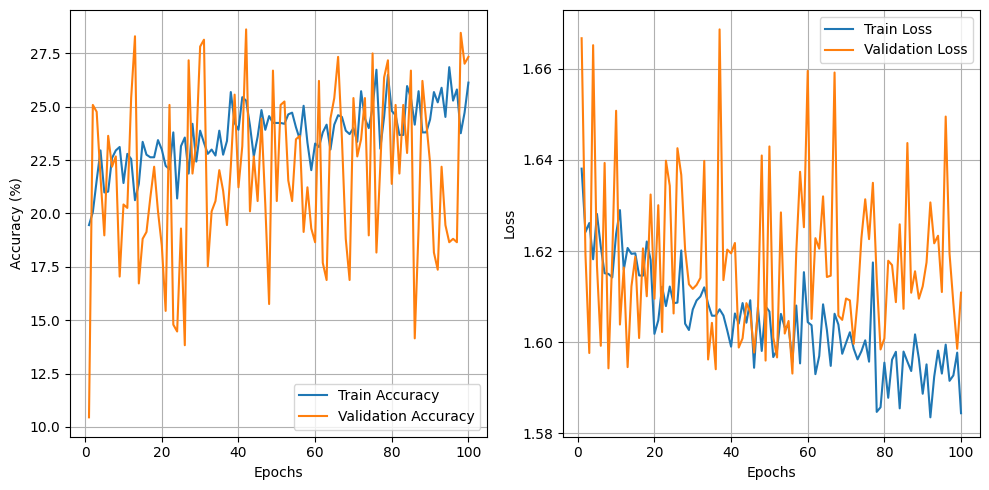

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v3/representacion_3/longitud_28/{nombre_modelo}.png')
plt.show()

***Cargar el modelo :***

In [10]:
#modelo = get_densenet121_model(num_classes=num_classes, pretrained=True).to(device)

modelo.load_state_dict(torch.load("./Modelos/v3/representacion_3/longitud_28/ConvNext_Tiny_fold_3.pth"))
modelo.to(device)
modelo.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

***Evaluar el modelo :***

In [11]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Matriz de confusión :***

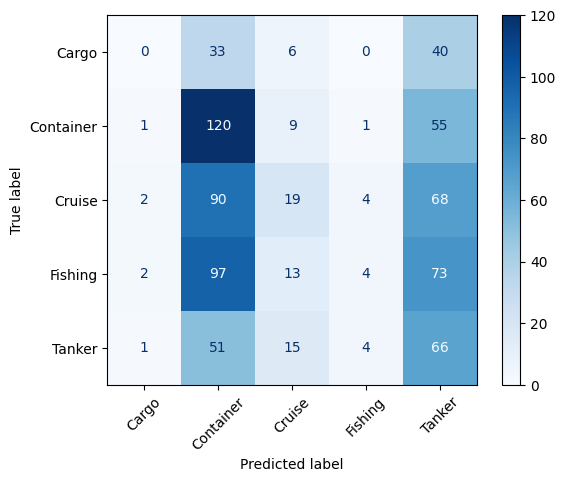

In [12]:
class_names = ['Cargo','Container','Cruise','Fishing','Tanker']
#class_names = ['Cargo', 'Container','Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v3/representacion_3/longitud_28')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'ConvNext_Tiny_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       0.15      0.09      0.11        79
   Container       0.29      0.28      0.29       186
      Cruise       0.25      0.37      0.30       183
     Fishing       0.25      0.27      0.26       189
      Tanker       0.28      0.14      0.19       137

    accuracy                           0.25       774
   macro avg       0.24      0.23      0.23       774
weighted avg       0.25      0.25      0.25       774

